In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [20]:
#import data from SQLite using sqlalchemy
engine = create_engine("sqlite:///mta_data.db")
df = pd.read_sql('SELECT * FROM mta_data',engine)

In [21]:
## Clean Data

#Convert DATE column to DATETIME
df["DATE_TIME"] =  pd.to_datetime(df.DATE + ' ' + df.TIME)
df["DATE"] = pd.to_datetime(df.DATE)

#Add YEAR column
df["YEAR"] = pd.DatetimeIndex(df['DATE']).year

#Filter on just 2019 and 2022 data
df = df[df["YEAR"].isin(['2019','2022'])]

In [50]:

df2 = df.groupby(["C/A","UNIT","SCP","STATION","DATE","YEAR"]).agg({"ENTRIES":"max","EXITS":"max"}).reset_index()
#Below is from stackoverflow.com/questions/37997668
df2 = df2.sort_values(["STATION","SCP","UNIT","C/A","DATE"])
df2['row_count'] = df2.groupby(["C/A","UNIT","SCP","STATION","YEAR"]).cumcount()+1

df2["ENTRIES_PREV_DAY"] = df2.ENTRIES.shift(1) 
df2["EXITS_PREV_DAY"] = df2.EXITS.shift(1)
df2 = df2[~df2.row_count.isin(['1'])]

#Convert new columns to integers
df2["ENTRIES_PREV_DAY"] = df2.ENTRIES_PREV_DAY.astype('int')
df2["EXITS_PREV_DAY"] = df2.EXITS_PREV_DAY.astype('int')

#Create new columns for daily exits and entries
df2["DAILY_EXITS"] = df2.EXITS - df2.EXITS_PREV_DAY
df2["DAILY_ENTRIES"] = df2.ENTRIES - df2.ENTRIES_PREV_DAY


In [29]:
df2

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,row_count,ENTRIES_PREV_DAY,EXITS_PREV_DAY,DAILY_EXITS,DAILY_ENTRIES
177342,H007,R248,00-00-00,1 AV,2019-01-02,14281488,16011092,2,14277982,16007353,3739,3506
177343,H007,R248,00-00-00,1 AV,2019-01-03,14285396,16015222,3,14281488,16011092,4130,3908
177344,H007,R248,00-00-00,1 AV,2019-01-04,14289241,16019357,4,14285396,16015222,4135,3845
177345,H007,R248,00-00-00,1 AV,2019-01-05,14291511,16022688,5,14289241,16019357,3331,2270
177346,H007,R248,00-00-00,1 AV,2019-01-06,14293461,16025626,6,14291511,16022688,2938,1950
...,...,...,...,...,...,...,...,...,...,...,...,...
1016063,R419,R326,00-05-01,ZEREGA AV,2022-04-25,39,271,231,39,271,0,0
1016064,R419,R326,00-05-01,ZEREGA AV,2022-04-26,39,271,232,39,271,0,0
1016065,R419,R326,00-05-01,ZEREGA AV,2022-04-27,39,271,233,39,271,0,0
1016066,R419,R326,00-05-01,ZEREGA AV,2022-04-28,39,271,234,39,271,0,0


In [51]:
#(df2[df2["ENTRIES"] < df2["ENTRIES_PREV_DAY"]]
#    .groupby(["C/A", "UNIT", "SCP", "STATION"])
#    .size())
#Shows 1438 rows where Entries are less than previous day Exits show 1414 rows 
#Convert with function from mta solution 3
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["ENTRIES_PREV_DAY"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["ENTRIES_PREV_DAY"])
        counter = min(row["ENTRIES"], row["ENTRIES_PREV_DAY"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

def get_daily_counts2(row, max_counter):
    counter = row["EXITS"] - row["EXITS_PREV_DAY"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["EXITS_PREV_DAY"])
        counter = min(row["EXITS"], row["EXITS_PREV_DAY"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

df2["DAILY_ENTRIES"] = df2.apply(get_daily_counts, axis=1, max_counter=1000000)
df2["DAILY_EXITS"] = df2.apply(get_daily_counts2, axis=1, max_counter=1000000)

180 2900739
2221 1629651041
41 1562955740
2097089095 8585102
25415319 2097051992
18 5618940
197 3979479
764 9485331
3207 1334454
2061 192991053
16797438 92859
99505 16811551
1712 1276366720
1325 9456935
68448 11726783
1442824390 11149972
2030107008 7958143
989875877 3893876
498 2807329
2141 187389661
6954 9643166
3 50338124
23 119352792
3 117914878
22 5434751
1354 2117780
1816 7354911
235208427 68073706
3998 1830476
264702 5240415
5389855 325782
330797 5389892
1801 13588976
1511861 144337
152388 1511907
50349662 198255
134582410 476783
1385 12737464
773 1601058
589898 201491306
796367 920064693
1611 16059973
2827 13770219
1315 4971916
3942 8572096
580 1191921
12786 2479055
2836 3876009
2393 7054160
946 3663765
1649 6061304
2164857 6773620
3043 7118837
2296 11241357
710 51385377
266 1428035637
853271 6604854
3233 2874613
1279 5664363
250 2045975559
3335 1430820
402692234 1604665
590899 402692234
1929168974 59623014
3225 12368904
1063615591 10133831
1055323768 1063615462
1996226557 47867

In [55]:
#Add YEAR column again
df2["YEAR"] = pd.DatetimeIndex(df2['DATE']).year
#Create separate dataframes for 2022 and 2019 for easier graphing
df2022 = df2[df2["YEAR"]==2022].groupby(["STATION"]).agg({"DAILY_ENTRIES":"sum","DAILY_EXITS":"sum"}).reset_index()
df2019 = df2[df2["YEAR"]==2019].groupby(["STATION"]).agg({"DAILY_ENTRIES":"sum","DAILY_EXITS":"sum"}).reset_index()

In [59]:
dfcomp = pd.merge(df2022,df2019, on = "STATION")
dfcomp["ENTRY_CHANGE"] = dfcomp["DAILY_ENTRIES_x"] - dfcomp["DAILY_ENTRIES_y"]
dfcomp["EXITS_CHANGE"] = dfcomp["DAILY_EXITS_x"] - dfcomp["DAILY_EXITS_y"]
dfcomp["ENT_EXIT_CHANGE"] = dfcomp["ENTRY_CHANGE"] + dfcomp["EXITS_CHANGE"]
df2022_TopTen_ENT = df2022.sort_values(["DAILY_ENTRIES"],ascending=False).head(10)
df2019_TopTen_ENT = df2019.sort_values(["DAILY_ENTRIES"],ascending=False).head(10)
dfcomp_Top_Inc_ENT = dfcomp.sort_values(["ENTRY_CHANGE"],ascending=False).head(10)
dfcomp_Top_Dec_ENT = dfcomp.sort_values(["ENTRY_CHANGE"],ascending=True).head(10)
df2022_TopTen_EXT = df2022.sort_values(["DAILY_EXITS"],ascending=False).head(10)
df2019_TopTen_EXT = df2019.sort_values(["DAILY_EXITS"],ascending=False).head(10)
dfcomp_Top_Inc_EXT = dfcomp.sort_values(["EXITS_CHANGE"],ascending=False).head(10)
dfcomp_Top_Dec_EXT = dfcomp.sort_values(["EXITS_CHANGE"],ascending=True).head(10)
dfcomp_Top_Inc_BOTH = dfcomp.sort_values(["ENT_EXIT_CHANGE"],ascending=False).head(10)
dfcomp_Top_Dec_BOTH = dfcomp.sort_values(["ENT_EXIT_CHANGE"],ascending=True).head(10)
dfcomp_Top_Inc_BOTH

,STATION,DAILY_ENTRIES_x,DAILY_EXITS_x,DAILY_ENTRIES_y,DAILY_EXITS_y,ENTRY_CHANGE,EXITS_CHANGE,ENT_EXIT_CHANGE
0,1 AV,3681848,3700022,1860755,2082313,1821093,1617709,3438802
258,JOURNAL SQUARE,4738779,3436541,3083335,3440288,1655444,-3747,1651697
130,AVENUE M,705419,535137,563012,236407,142407,298730,441137
346,SUTPHIN BLVD,545174,602216,437569,285603,107605,316613,424218
300,NEWARK HM HE,364349,4075007,669451,3560272,-305102,514735,209633
350,THIRTY ST,2305231,518317,1643574,1042483,661657,-524166,137491
275,LORIMER ST,493266,1136271,1006202,505061,-512936,631210,118274
108,82 ST-JACKSON H,1341962,1950993,1474681,1757281,-132719,193712,60993
328,RIT-MANHATTAN,320435,38689,332109,5212,-11674,33477,21803
133,AVENUE U,1303825,486381,1214160,558637,89665,-72256,17409


In [60]:
dfcomp_Top_Dec_BOTH

,STATION,DAILY_ENTRIES_x,DAILY_EXITS_x,DAILY_ENTRIES_y,DAILY_EXITS_y,ENTRY_CHANGE,EXITS_CHANGE,ENT_EXIT_CHANGE
61,34 ST-PENN STA,5320793,8230673,22163113,19362173,-16842320,-11131500,-27973820
59,34 ST-HERALD SQ,4051890,6126451,19577285,13585046,-15525395,-7458595,-22983990
233,GRD CNTRL-42 ST,4885463,7304786,15380344,13117676,-10494881,-5812890,-16307771
46,23 ST,3826903,5005445,13071104,10420582,-9244201,-5415137,-14659338
14,14 ST-UNION SQ,3374882,5577644,10883809,9612023,-7508927,-4034379,-11543306
226,FULTON ST,3447540,5016536,9472650,10062899,-6025110,-5046363,-11071473
173,CANAL ST,3047823,3588072,9377616,8242048,-6329793,-4653976,-10983769
352,TIMES SQ-42 ST,3246134,5087195,9970903,9165355,-6724769,-4078160,-10802929
68,42 ST-PORT AUTH,3770272,5054883,10410829,8077456,-6640557,-3022573,-9663130
72,47-50 STS ROCK,1792677,2837176,5604357,5814777,-3811680,-2977601,-6789281


In [71]:

df_samp = pd.concat([dfcomp_Top_Dec_BOTH,dfcomp_Top_Inc_BOTH],ignore_index=True)

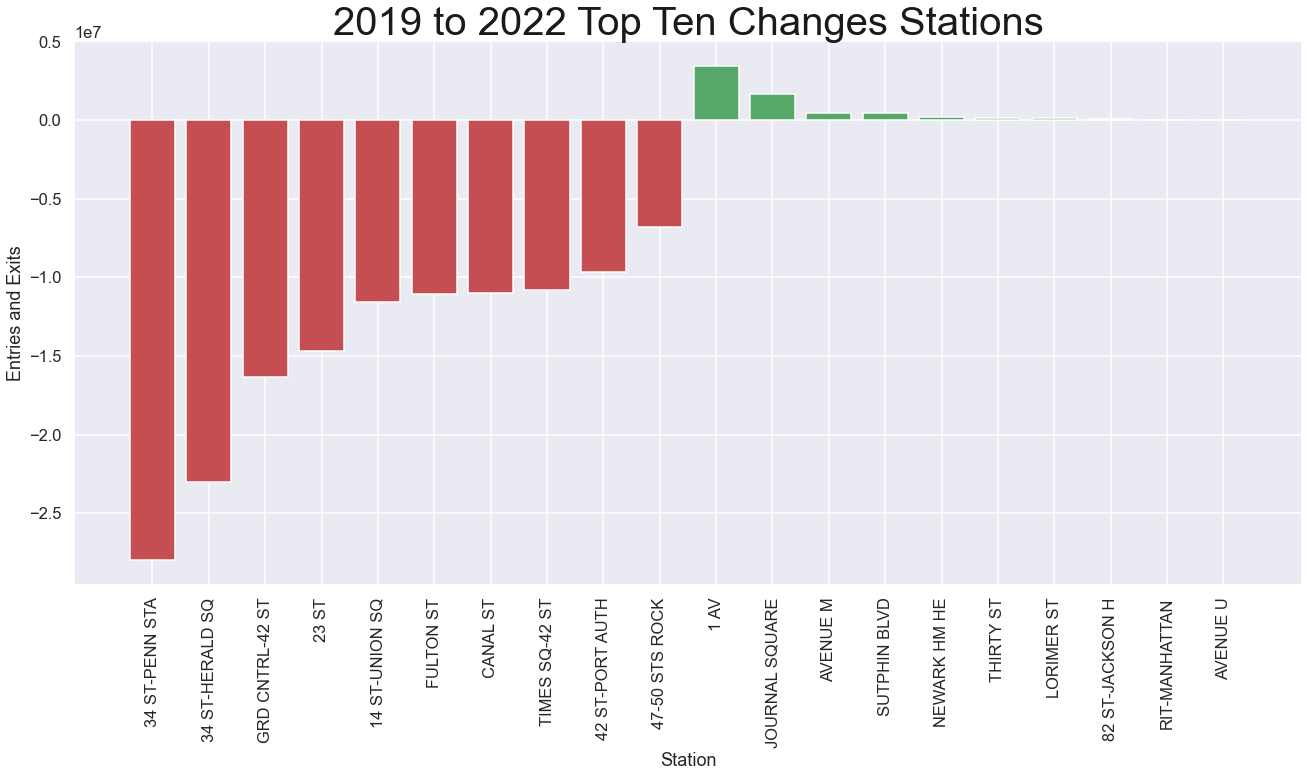

In [146]:
#figure.set_dpi(100)
figure(figsize=[22,10])
sns.set_context("talk")
plt.title('2019 to 2022 Top Ten Changes Stations',fontsize=40,color = 'k',wrap = True)
plt.xlabel('Station')
plt.ylabel('Entries and Exits')
plt.xticks(rotation = 90)
#Color map from Stack Overflow https://stackoverflow.com/questions/22311139/ 
plt.bar(df_samp.STATION,df_samp.ENT_EXIT_CHANGE,color=(df_samp.ENT_EXIT_CHANGE > 0).map({True:'g',False:'r'}));

In [78]:
sns.set_theme()

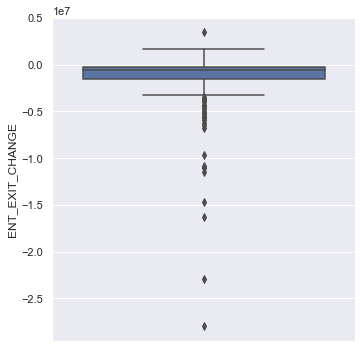

In [82]:
sns.catplot(y="ENT_EXIT_CHANGE",kind="box",data = dfcomp)

In [84]:
dfcomp

,STATION,DAILY_ENTRIES_x,DAILY_EXITS_x,DAILY_ENTRIES_y,DAILY_EXITS_y,ENTRY_CHANGE,EXITS_CHANGE,ENT_EXIT_CHANGE
0,1 AV,3681848,3700022,1860755,2082313,1821093,1617709,3438802
1,103 ST,1488385,1686104,3018176,2140495,-1529791,-454391,-1984182
2,103 ST-CORONA,1221239,1449219,1998763,1493201,-777524,-43982,-821506
3,104 ST,230987,161453,440117,218664,-209130,-57211,-266341
4,110 ST,526379,753522,1068185,959981,-541806,-206459,-748265
...,...,...,...,...,...,...,...,...
373,WOODLAWN,342575,137078,659117,143095,-316542,-6017,-322559
374,WORLD TRADE CTR,542710,687597,1962564,1365723,-1419854,-678126,-2097980
375,WTC-CORTLANDT,449215,637886,1294027,1019984,-844812,-382098,-1226910
376,YORK ST,421042,494998,1139112,521202,-718070,-26204,-744274


In [87]:
dfcomp["PERCENT_CHANGE"] = dfcomp["ENT_EXIT_CHANGE"]/(dfcomp["DAILY_ENTRIES_x"]+dfcomp["DAILY_EXITS_x"])

In [151]:
dfcomp3 = pd.merge(df2022,df2019, on = "STATION")
dfcomp3["ENTRY_CHANGE"] = dfcomp3["DAILY_ENTRIES_x"] - dfcomp3["DAILY_ENTRIES_y"]
dfcomp3["EXITS_CHANGE"] = dfcomp3["DAILY_EXITS_x"] - dfcomp3["DAILY_EXITS_y"]
dfcomp3["ENT_EXIT_CHANGE"] = dfcomp3["ENTRY_CHANGE"] + dfcomp3["EXITS_CHANGE"]
dfcomp3["PERCENT_CHANGE"] = dfcomp3["ENT_EXIT_CHANGE"]/(dfcomp3["DAILY_ENTRIES_x"]+dfcomp3["DAILY_EXITS_x"])

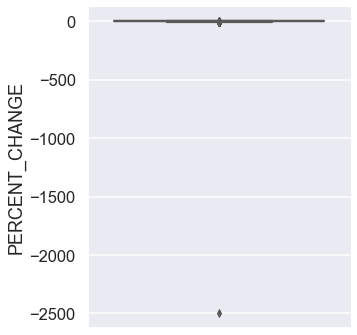

In [152]:
sns.catplot(y="PERCENT_CHANGE",kind="box",data = dfcomp3)

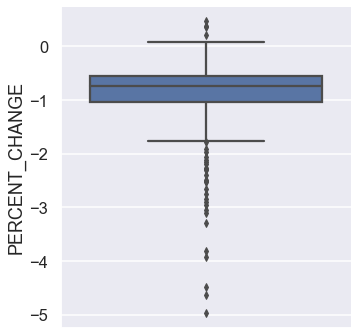

In [127]:
sns.catplot(y="PERCENT_CHANGE",kind="box",data = dfcomp[dfcomp["PERCENT_CHANGE"]>-5])

In [91]:
dfcomp = dfcomp.sort_values(["PERCENT_CHANGE"])
dfcomp[dfcomp["PERCENT_CHANGE"]<-1]

,STATION,DAILY_ENTRIES_x,DAILY_EXITS_x,DAILY_ENTRIES_y,DAILY_EXITS_y,ENTRY_CHANGE,EXITS_CHANGE,ENT_EXIT_CHANGE,PERCENT_CHANGE
186,CLARK ST,50,300,570245,304263,-570195,-303963,-874158,-2497.594286
119,ALLERTON AV,251517,172286,517474,2012497,-265957,-1840211,-2106168,-4.969686
127,AVENUE H,151597,202095,958563,1030294,-806966,-828199,-1635165,-4.623133
8,121 ST,111572,100122,1022237,137283,-910665,-37161,-947826,-4.477340
222,FRANKLIN ST,191938,195502,1523549,385804,-1331611,-190302,-1521913,-3.928126
...,...,...,...,...,...,...,...,...,...
47,231 ST,465936,78506,970978,135247,-505042,-56741,-561783,-1.031851
357,UTICA AV,620495,843272,1652202,1311876,-1031707,-468604,-1500311,-1.024966
159,BOWLING GREEN,987147,1788801,3099299,2485733,-2112152,-696932,-2809084,-1.011937
221,FRANKLIN AV,775730,986536,2062754,1477286,-1287024,-490750,-1777774,-1.008800


<AxesSubplot:ylabel='STATION'>

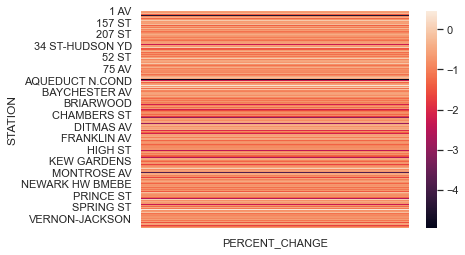

In [96]:
dfcomp_heat = dfcomp.groupby(["STATION"]).agg({"PERCENT_CHANGE":"sum"})
sns.heatmap(dfcomp_heat[dfcomp_heat["PERCENT_CHANGE"]>-5])

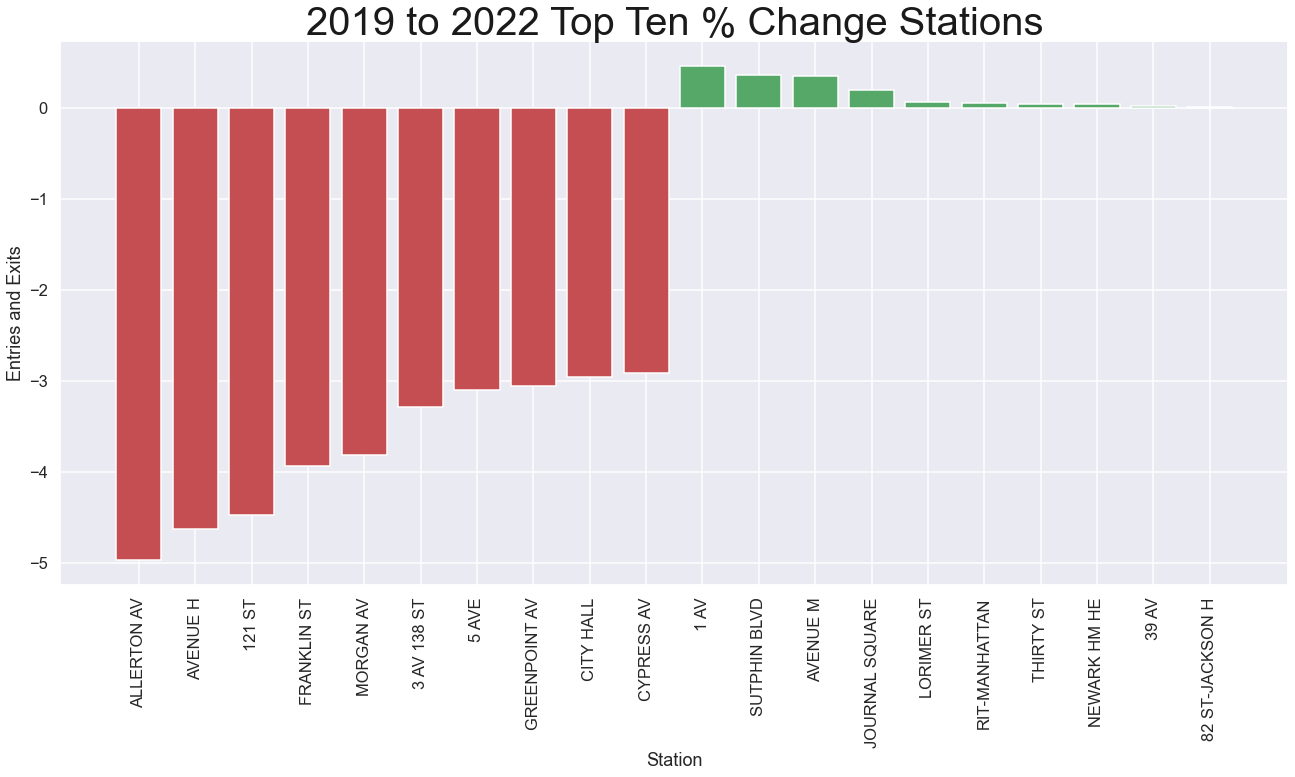

In [147]:
dfcomp = dfcomp[dfcomp["PERCENT_CHANGE"]>-5]
dfcomp_Top_Inc_BOTH = dfcomp.sort_values(["PERCENT_CHANGE"],ascending=False).head(10)
dfcomp_Top_Dec_BOTH = dfcomp.sort_values(["PERCENT_CHANGE"],ascending=True).head(10)
df_samp2 = pd.concat([dfcomp_Top_Dec_BOTH,dfcomp_Top_Inc_BOTH],ignore_index=True)

#figure.set_dpi(100)
figure(figsize=[22,10])
plt.title('2019 to 2022 Top Ten % Change Stations',fontsize=40,color = 'k',wrap = True)
plt.xlabel('Station')
plt.ylabel('Entries and Exits')
plt.xticks(rotation = 90)
#Color map from Stack Overflow https://stackoverflow.com/questions/22311139/ 
plt.bar(df_samp2.STATION,df_samp2.PERCENT_CHANGE,color=(df_samp2.PERCENT_CHANGE > 0).map({True:'g',False:'r'}));

In [103]:
df2

,C/A,UNIT,SCP,STATION,DATE,YEAR,ENTRIES,EXITS,row_count,ENTRIES_PREV_DAY,EXITS_PREV_DAY,DAILY_EXITS,DAILY_ENTRIES
177342,H007,R248,00-00-00,1 AV,2019-01-02,2019,14281488,16011092,2,14277982,16007353,3739,3506
177343,H007,R248,00-00-00,1 AV,2019-01-03,2019,14285396,16015222,3,14281488,16011092,4130,3908
177344,H007,R248,00-00-00,1 AV,2019-01-04,2019,14289241,16019357,4,14285396,16015222,4135,3845
177345,H007,R248,00-00-00,1 AV,2019-01-05,2019,14291511,16022688,5,14289241,16019357,3331,2270
177346,H007,R248,00-00-00,1 AV,2019-01-06,2019,14293461,16025626,6,14291511,16022688,2938,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016063,R419,R326,00-05-01,ZEREGA AV,2022-04-25,2022,39,271,115,39,271,0,0
1016064,R419,R326,00-05-01,ZEREGA AV,2022-04-26,2022,39,271,116,39,271,0,0
1016065,R419,R326,00-05-01,ZEREGA AV,2022-04-27,2022,39,271,117,39,271,0,0
1016066,R419,R326,00-05-01,ZEREGA AV,2022-04-28,2022,39,271,118,39,271,0,0


In [106]:
df_line = df2.groupby(["YEAR","DATE"]).agg({"DAILY_ENTRIES":"sum","DAILY_EXITS":"sum"}).reset_index()

In [108]:
df_line

,YEAR,DATE,DAILY_ENTRIES,DAILY_EXITS
0,2019,2019-01-02,5286662,4117057
1,2019,2019-01-03,6002598,4497918
2,2019,2019-01-04,5672654,4394273
3,2019,2019-01-05,3063751,2884997
4,2019,2019-01-06,3150799,3652790
...,...,...,...,...
228,2022,2022-04-25,2303340,3254201
229,2022,2022-04-26,2904344,3513457
230,2022,2022-04-27,2631949,3292959
231,2022,2022-04-28,2745596,3496614


In [110]:
df_line["ENT_EXITS"] = df_line["DAILY_ENTRIES"] + df_line["DAILY_EXITS"]
#Below from Solution mta 3 Problem 9
df_line["WEEK_OF_YEAR"] = pd.to_datetime(df_line["DATE"]).dt.week

<ipython-input-110-f407e1bc2bcf>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_line["WEEK_OF_YEAR"] = pd.to_datetime(df_line["DATE"]).dt.week


In [137]:
df_line2 = df_line.groupby(["YEAR","WEEK_OF_YEAR"]).agg({"ENT_EXITS":"sum"}).reset_index()

df_line2 = df_line2[df_line2["WEEK_OF_YEAR"]<17]
df_line2 = df_line2[df_line2["WEEK_OF_YEAR"]>1]

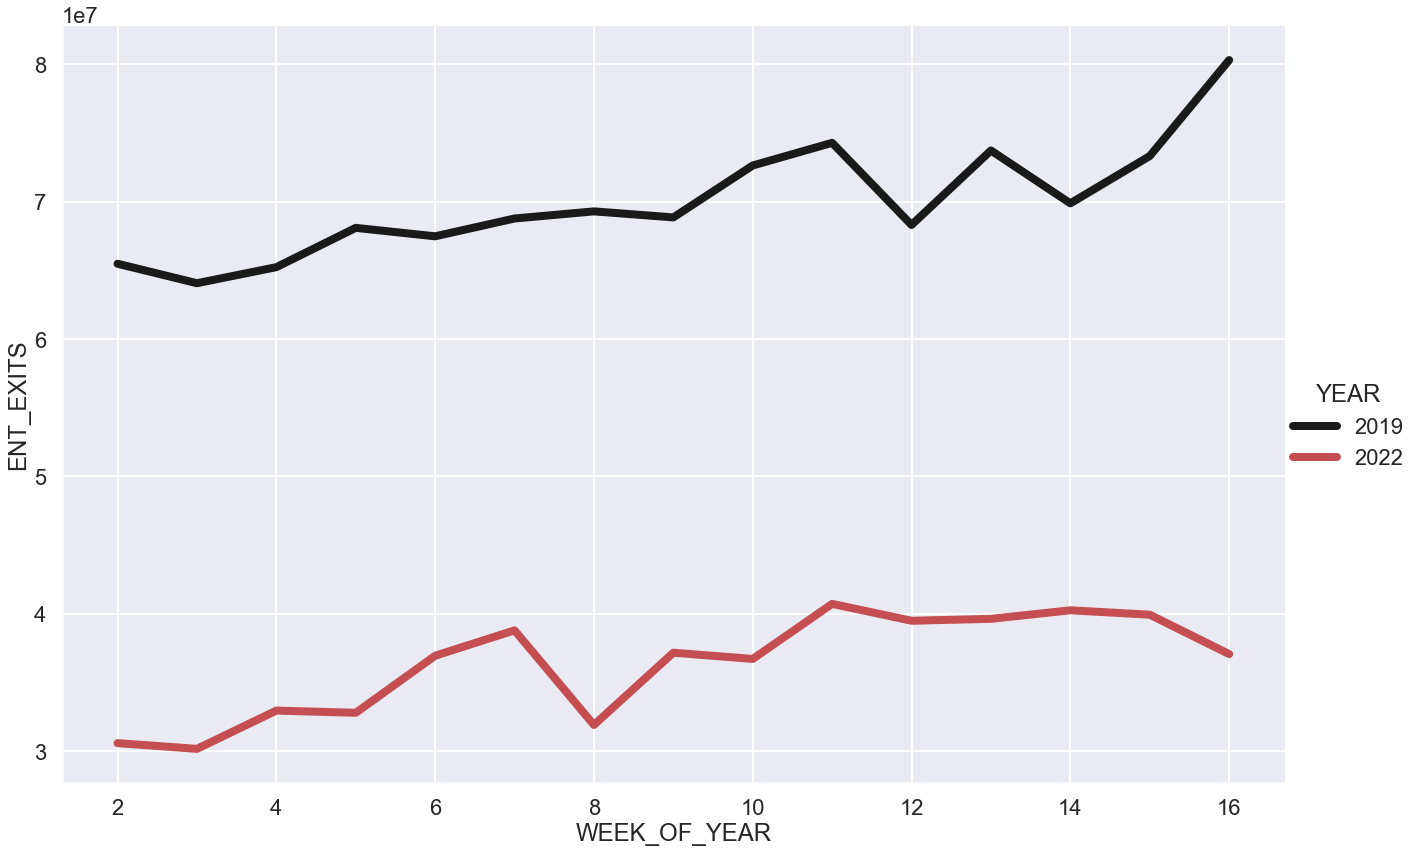

In [153]:

sns.set_context("poster",rc={"lines.linewidth":8,"figure.figsize":(20,16)})
#sns.set(rc="figure.figsize:(12,8)"})
sns.relplot(x="WEEK_OF_YEAR",y="ENT_EXITS",kind="line",hue = "YEAR",data = df_line2,palette=["k","r"],height=12,aspect=12/8)

In [154]:
df_line2

,YEAR,WEEK_OF_YEAR,ENT_EXITS
1,2019,2,65478111
2,2019,3,64060108
3,2019,4,65227364
4,2019,5,68088644
5,2019,6,67473636
6,2019,7,68770292
7,2019,8,69288264
8,2019,9,68849768
9,2019,10,72629161
10,2019,11,74279352
